# Лабораторная работа №5 - **Проведение исследований с градиентным бустингом**

### Тема 1 (Классификация): Предсказание уровня развития страны (Low/Medium/High)

- **Датасет: Countries of the World 2023**

### Тема 2 (Регрессия): Предсказание индекса климатических рисков

- **Датасет: Global Climate Change Data 2020-2025**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

import warnings
warnings.filterwarnings('ignore')


# Вспомогательные функции

# Вывод основных метрик классификации
def print_classification_results(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro', zero_division=0))
    print("F1 (macro):", f1_score(y_true, y_pred, average='macro', zero_division=0))
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred, zero_division=0))

# Вывод основных метрик регрессии
def print_regression_results(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mse)
    print("RMSE:", np.sqrt(mse))
    print("R2:", r2_score(y_true, y_pred))

Загрузка датасетов
- `data/countries.csv` — датасет про страны
- `data/climate.csv` — климатический датасет

In [ ]:
countries_path = 'data/countries.csv'
climate_path = 'data/climate.csv'

# Загрузка датасетов
countries = pd.read_csv(countries_path)
climate = pd.read_csv(climate_path)

# Вывод размеров таблиц
print('Countries shape:', countries.shape)
print('Climate shape:', climate.shape)

Countries shape: (195, 35)
Climate shape: (1200, 7)


# 1. Выбор начальных условий

### a. Выбрать набор данных для задачи классификации - Предсказание уровня развития страны


Просмотрим, как выглядят таблицы:

In [3]:
countries.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


### b. Выбрать набор данных для задачи регрессии - Задача по предсказанию баллов за экзамен у студентов

In [4]:
climate.head()

,Year,Continent,Country,Avg_Temperature(°C),CO2_Emissions(Mt),Sea_Level_Rise(mm),Climate_Risk_Index
0,2021,Europe,UK,19.6,978.24,3.57,28
1,2022,Asia,India,25.3,770.39,1.47,74
2,2022,Asia,Japan,23.2,963.84,3.09,48
3,2020,North America,Mexico,20.8,349.49,3.81,23
4,2024,Africa,Egypt,33.1,475.82,3.35,86


### c. Выбрать метрики качества и обосновать их выбор

#### Метрики выбранные для Датасета про Страны (Классификация):
1. Accuracy - Базовая метрика классификации, показывает долю правильно предсказанных стран. Подходит, если классы относительно сбалансированы.
2. Precision (macro) - Усредняет precision по каждому классу одинаково. Подходит, если важно не "завышать" уровень развития страны (например, ошибочно классифицировать Low как High).
3. Recall (macro)- Равномерно учитывает полноту по каждому классу. Важно, если нужно не пропустить случаи низкого или высокого уровня развития.
4. F1-score (macro) - Гармоническое среднее precision и recall. Хорошо подходит, если распределение классов несбалансированное и нужно адекватно учитывать качество по всем классам.

#### Метрики выбранные для Датасета про Климат (Регрессия):
1. MAE (Mean Absolute Error) - Средняя абсолютная ошибка. Простая и интерпретируемая метрика, устойчивая к выбросам. Показывает, насколько модель в среднем ошибается при прогнозе климатического риска.
2. RMSE (Root Mean Square Error) - Корень из MSE, имеет те же единицы измерения, что и целевая переменная. Удобна для интерпретации.
3. MSE (Mean Squared Error) - Усиливает штраф за крупные ошибки. Полезно, если важно сильнее учитывать резкие изменения показателей (скачки CO2, температуры).
4. R^2 (Coefficient of Determination) - Показывает, насколько хорошо модель объясняет изменение индекса климатических рисков. Удобна для сравнения моделей.

# 2. Создание бейзлайна и оценка качества

### Подготовка данных (Классификация)

Предобработка и подготовка целевой переменной - классификация (Countries)

Цель: сформировать целевую переменную уровня развития страны на основе GDP per capita.

In [ ]:
# Функция для парсинга денежных значений
def parse_money(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x).replace('$','').replace(',','').strip()
    try:
        return float(s)
    except:
        return np.nan
    
# Функция для парсинга целых чисел
def parse_int(x):
    if pd.isna(x):
        return np.nan
    try:
        return int(str(x).replace(',','').strip())
    except:
        try:
            return int(float(x))
        except:
            return np.nan

# Применяем парсинг
countries['GDP_num'] = countries['GDP'].apply(parse_money)
countries['Population_num'] = countries['Population'].apply(parse_int)

# Рассчитываем ВВП на душу населения
countries['GDP_per_capita'] = countries['GDP_num'] / countries['Population_num']

# Выводим статистику по новому признаку
countries['GDP_per_capita'].describe()

count       193.000000
mean      15690.877246
std       25268.434004
min         261.247473
25%        1912.903745
50%        5955.109010
75%       17401.721516
max      184396.986783
Name: GDP_per_capita, dtype: float64

Создадим целевые классы по GDP_per_capita: Low / Medium / High.

In [ ]:
# Определяем квантили для разбиения на классы
q1 = countries['GDP_per_capita'].quantile(0.33)
q2 = countries['GDP_per_capita'].quantile(0.66)
q1, q2

# Функция для присвоения класса уровня развития
def cap_class(x, q1=q1, q2=q2):
    if pd.isna(x):
        return np.nan
    if x <= q1:
        return 'Low'
    elif x <= q2:
        return 'Medium'
    else:
        return 'High'

# Создаем целевую переменную DevelopmentClass
countries['DevelopmentClass'] = countries['GDP_per_capita'].apply(cap_class)

# Удаляем строки с пропущенным целевым классом
countries = countries.dropna(subset=['DevelopmentClass'])
print('After dropping NA:', countries.shape)

After dropping NA: (193, 39)


Выберем признаки: возьмём набор числовых признаков, которые логично влияют на уровень развития.

Например: Population_num, Life expectancy, GDP_per_capita (мы не можем использовать GDP_per_capita — он использовался для метки),
Physicians per thousand (Physicians per thousand), Unemployment rate, Urban_population, Literacy/education enrollment if present.


In [ ]:
countries.columns.tolist()

# Очистка названий столбцов от пробелов
cols = [c.strip() for c in countries.columns]

candidates = ['Population_num', 'Life expectancy', 'Infant mortality', 'Physicians per thousand',
              'Unemployment rate', 'Urban_population', 'Fertility Rate', 'CPI', 'GDP_num']

countries = countries.rename(columns=lambda s: s.strip())

# Замена пробелов на подчеркивание в названиях столбцов
countries.columns = [c.replace(' ', '_') for c in countries.columns]

# Отбор признаков, которые присутствуют в датасете
features = []
for name in ['Population_num','Life_expectancy','Infant_mortality','Physicians_per_thousand',
             'Unemployment_rate','Urban_population','Fertility_Rate','CPI','Land_Area(Km2)']:
    if name in countries.columns:
        features.append(name)

print('Selected features:', features)


# Выбор числовых колонок
num_cols = countries.select_dtypes(include=['number']).columns.tolist()

# Исключение целевых и служебных признаков из списка предикторов
exclude = ['GDP_per_capita','GDP_num','Latitude','Longitude']
X_num = [c for c in num_cols if c not in exclude]

print('Numeric candidate columns (sample):', X_num[:20])

Selected features: ['Population_num', 'Life_expectancy', 'Infant_mortality', 'Physicians_per_thousand', 'Unemployment_rate', 'Urban_population', 'Fertility_Rate', 'CPI', 'Land_Area(Km2)']
Numeric candidate columns (sample): ['Birth_Rate', 'Calling_Code', 'Fertility_Rate', 'Infant_mortality', 'Life_expectancy', 'Maternal_mortality_ratio', 'Physicians_per_thousand', 'Population_num']


### Корреляционный анализ признаков для классификации


Построим корреляционную матрицу для числовых признаков, которые используются в задаче классификации. Это поможет увидеть, какие признаки сильно коррелируют друг с другом и потенциально могут быть избыточными.

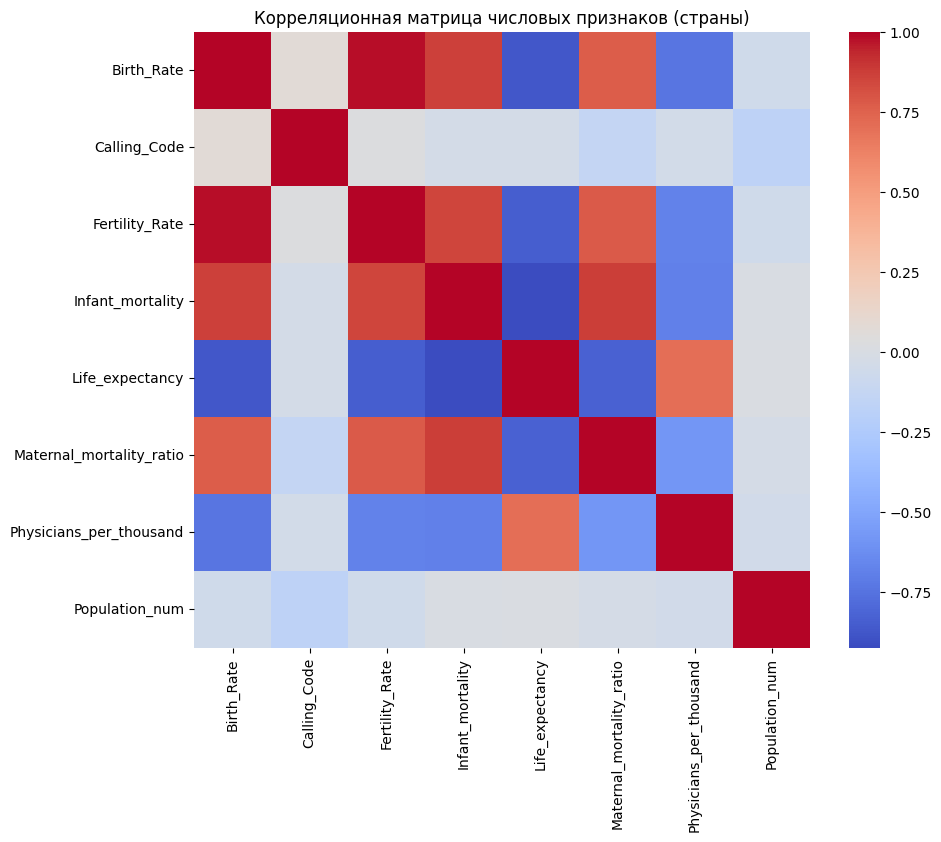

In [ ]:
plt.figure(figsize=(10,8))

# Вычисление корреляции Пирсона
corr_c = countries[X_num].corr()

# Визуализация
sns.heatmap(corr_c, annot=False, cmap='coolwarm', square=True)
plt.title('Корреляционная матрица числовых признаков (страны)')
plt.show()

### a. Обучить модели из sklearn (для классификации) для выбранных наборов данных
### b. Оценить качество моделей (для классификации) по выбранным метрикам на выбранных наборах данных

In [ ]:
# Формирование матрицы признаков X и вектора целевой переменной y
X_class = countries[X_num].copy()
y_class = countries['DevelopmentClass'].copy()

# Удаление столбцов с большим количеством пропусков
threshold_col = 0.4 * len(X_class)
cols_keep = [c for c in X_class.columns if X_class[c].isna().sum() <= threshold_col]
X_class = X_class[cols_keep]
print('Columns kept:', len(cols_keep))

# Объединение и удаление строк с пропусками
df_class = pd.concat([X_class, y_class], axis=1).dropna()
X_class = df_class[X_class.columns]
y_class = df_class['DevelopmentClass']
print('Final shape (classification):', X_class.shape)

Columns kept: 8
Final shape (classification): (180, 8)


Baseline KNN для классификации (sklearn)

In [ ]:
# Разделение на train и test со стратификацией
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, stratify=y_class, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

# Обучение базового Градиентного Бустинга
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_c_scaled, y_train_c)


# Предсказание и оценка
y_pred_c = gb_clf.predict(X_test_c_scaled)
print('Baseline classification results (Gradient Boosting):')
print_classification_results(y_test_c, y_pred_c)

Baseline classification results (Gradient Boosting):
Accuracy: 0.8611111111111112
Precision (macro): 0.8714285714285714
Recall (macro): 0.8607226107226107
F1 (macro): 0.8593939393939394

Classification report:

              precision    recall  f1-score   support

        High       0.90      0.75      0.82        12
         Low       1.00      0.92      0.96        13
      Medium       0.71      0.91      0.80        11

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.88      0.86      0.86        36



# 3. Улучшение бейзлайна

### a. Сформулировать гипотезы (препроцессинг данных, визуализация данных, формирование новых признаков, подбор гиперпараметров на кросс-валидации и т.д.)

Гипотезы:
- Подбор k и метрики расстояния (p) на кросс-валидации
- Удаление коррелированных признаков
- Балансировка классов

### b-e. Проверка гипотез и улучшение (Классификация)

In [ ]:
# Сетка параметров: кол-во деревьев, скорость обучения, глубина
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Поиск лучших параметров
grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=cv, scoring='f1_macro')
grid.fit(X_train_c_scaled, y_train_c)
print('Best params:', grid.best_params_) 

# Оценка лучшей модели
best_clf = grid.best_estimator_
y_pred_c_best = best_clf.predict(X_test_c_scaled)
print('Improved classification results:')
print_classification_results(y_test_c, y_pred_c_best)

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Improved classification results:
Accuracy: 0.7777777777777778
Precision (macro): 0.7884615384615384
Recall (macro): 0.7744755244755245
F1 (macro): 0.7777777777777777

Classification report:

              precision    recall  f1-score   support

        High       0.75      0.75      0.75        12
         Low       1.00      0.85      0.92        13
      Medium       0.62      0.73      0.67        11

    accuracy                           0.78        36
   macro avg       0.79      0.77      0.78        36
weighted avg       0.80      0.78      0.78        36



# 4. Имплементация алгоритма машинного обучения

### a-c. Реализация и оценка (Классификация)

Реализация KNN с нуля (классификация)

In [ ]:
class GradientBoostingFromScratchClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.classes = None
        
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        X = np.asarray(X)
        # Onehot encoding целевой переменной
        y_encoded = np.zeros((len(y), n_classes))
        for i, c in enumerate(self.classes):
            y_encoded[:, i] = (y == c).astype(int)
            
        # Инициализация F (логитов) нулями
        self.F = np.zeros((len(y), n_classes))
        
        for _ in range(self.n_estimators):
            # Вычисление вероятностей через softmax
            probs = self._softmax(self.F)
            # Вычисление антиградиента (остатков)
            residuals = y_encoded - probs
            
            trees_iter = []
            for k in range(n_classes):
                # Обучение регрессионного дерева на остатках класса k
                tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
                tree.fit(X, residuals[:, k])
                trees_iter.append(tree)
                
                # Обновление F (логитов)
                update = tree.predict(X)
                self.F[:, k] += self.learning_rate * update
                
            self.trees.append(trees_iter)
        return self
            
    def _softmax(self, z):
        # Softmax с защитой от переполнения
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)

    def predict(self, X):
        X = np.asarray(X)
        F_pred = np.zeros((len(X), len(self.classes)))
        
        # Суммирование предсказаний всех деревьев
        for trees_iter in self.trees:
            for k, tree in enumerate(trees_iter):
                F_pred[:, k] += self.learning_rate * tree.predict(X)
                
        # Преобразование логитов в вероятности
        probs = self._softmax(F_pred)
        return self.classes[np.argmax(probs, axis=1)]


print("Training custom Gradient Boosting Classifier (Default: n_estimators=100, lr=0.1)...")
gb_scratch_simple = GradientBoostingFromScratchClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_scratch_simple.fit(X_train_c_scaled, y_train_c)
y_pred_c_scratch_simple = gb_scratch_simple.predict(X_test_c_scaled)

print('From-scratch Gradient Boosting (Default) results:')
print_classification_results(y_test_c, y_pred_c_scratch_simple)

best_n_est = grid.best_params_.get('n_estimators', 100)
best_lr = grid.best_params_.get('learning_rate', 0.1)
best_depth = grid.best_params_.get('max_depth', 3)

print(f"\nTraining custom Gradient Boosting (Optimized: n_est={best_n_est}, lr={best_lr}, depth={best_depth})...")
gb_scratch_best = GradientBoostingFromScratchClassifier(
    n_estimators=best_n_est, 
    learning_rate=best_lr, 
    max_depth=best_depth
)
gb_scratch_best.fit(X_train_c_scaled, y_train_c)
y_pred_c_scratch_best = gb_scratch_best.predict(X_test_c_scaled)

print('From-scratch Gradient Boosting (Optimized) results:')
print_classification_results(y_test_c, y_pred_c_scratch_best)

Training custom Gradient Boosting Classifier (Default: n_estimators=100, lr=0.1)...
From-scratch Gradient Boosting (Default) results:
Accuracy: 0.8611111111111112
Precision (macro): 0.8714285714285714
Recall (macro): 0.8607226107226107
F1 (macro): 0.8593939393939394

Classification report:

              precision    recall  f1-score   support

        High       0.90      0.75      0.82        12
         Low       1.00      0.92      0.96        13
      Medium       0.71      0.91      0.80        11

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.88      0.86      0.86        36


Training custom Gradient Boosting (Optimized: n_est=100, lr=0.1, depth=5)...
From-scratch Gradient Boosting (Optimized) results:
Accuracy: 0.8611111111111112
Precision (macro): 0.8714285714285714
Recall (macro): 0.8607226107226107
F1 (macro): 0.8593939393939394

Classification report:

              precision    recall  f1-s

### d-e. Сравнение и выводы (Классификация)

Подведение итогов по классификации

Сравнение метрик baseline sklearn, улучшенного GridSearch и собственной реализации.

In [ ]:
print('--- Classification summary ---')
print('1. Baseline (sklearn GradientBoosting):')
print_classification_results(y_test_c, gb_clf.predict(X_test_c_scaled))

print('\n2. Improved (sklearn GridSearch):')
print_classification_results(y_test_c, y_pred_c_best)

print('\n3. From-scratch (Default):')
print_classification_results(y_test_c, y_pred_c_scratch_simple)

print('\n4. From-scratch (Optimized):')
print_classification_results(y_test_c, y_pred_c_scratch_best)

--- Classification summary ---
1. Baseline (sklearn GradientBoosting):
Accuracy: 0.8611111111111112
Precision (macro): 0.8714285714285714
Recall (macro): 0.8607226107226107
F1 (macro): 0.8593939393939394

Classification report:

              precision    recall  f1-score   support

        High       0.90      0.75      0.82        12
         Low       1.00      0.92      0.96        13
      Medium       0.71      0.91      0.80        11

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.88      0.86      0.86        36


2. Improved (sklearn GridSearch):
Accuracy: 0.7777777777777778
Precision (macro): 0.7884615384615384
Recall (macro): 0.7744755244755245
F1 (macro): 0.7777777777777777

Classification report:

              precision    recall  f1-score   support

        High       0.75      0.75      0.75        12
         Low       1.00      0.85      0.92        13
      Medium       0.62      0.73 

# 2. Создание бейзлайна (Регрессия) - продолжение

### Подготовка данных (Регрессия)

Подготовка данных для регрессии (climate)

Цель: предсказать "Индекс климатических рисков" по признакам температуры, выбросам CO2 и повышению уровня моря.

In [ ]:
climate.head()

# Очистка названий столбцов
climate.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in climate.columns]

# Проверка наличия столбцов
for col in ['Средняя_температура_(C)','Выбросы_CO2_(млн_тонн)','Повышение_уровня_моря(мм)','Индекс_климатических_рисков','Country','Год']:
    if col not in climate.columns:
        print('Missing:', col)

print(climate.columns.tolist())

rename_map = {}
for c in climate.columns:
    lc = c.lower()
    if 'темпера' in lc:
        rename_map[c] = 'avg_temp'
    if 'co2' in lc or 'выброс' in lc:
        rename_map[c] = 'co2_emissions'
    if 'уровн' in lc and 'мор' in lc:
        rename_map[c] = 'sea_level_rise'
    if 'индекс' in lc and 'рис' in lc:
        rename_map[c] = 'climate_risk_index'
    if 'year' in lc or 'год' in lc:
        rename_map[c] = 'year'
    if 'country' in lc or 'страна' in lc:
        rename_map[c] = 'country'

# Переименование столбцов
climate = climate.rename(columns={
    'Avg_Temperature(°C)': 'avg_temp',
    'Sea_Level_Rise(mm)': 'sea_level_rise',
    'Climate_Risk_Index': 'climate_risk_index',
    **rename_map
})

print('After renaming:', climate.columns.tolist())

needed = ['avg_temp', 'co2_emissions', 'sea_level_rise', 'climate_risk_index']
missing_needed = [c for c in needed if c not in climate.columns]
print(missing_needed)

Missing: Средняя_температура_(C)
Missing: Выбросы_CO2_(млн_тонн)
Missing: Повышение_уровня_моря(мм)
Missing: Индекс_климатических_рисков
Missing: Год
['Year', 'Continent', 'Country', 'Avg_Temperature(°C)', 'CO2_Emissions(Mt)', 'Sea_Level_Rise(mm)', 'Climate_Risk_Index']
After renaming: ['year', 'Continent', 'country', 'avg_temp', 'co2_emissions', 'sea_level_rise', 'climate_risk_index']
[]


Формируем X и y для регрессии

In [ ]:
# Формирование X и y для регрессии
X_reg = climate[[c for c in ['avg_temp','co2_emissions','sea_level_rise'] if c in climate.columns]].copy()
y_reg = climate['climate_risk_index'].copy()

# Удаление пропусков
df_reg = pd.concat([X_reg, y_reg], axis=1).dropna()
X_reg = df_reg[X_reg.columns]
y_reg = df_reg['climate_risk_index']

print('Final shape (regression):', X_reg.shape)

Final shape (regression): (1200, 3)


### Корреляционная матрица для регрессионной задачи


Построим корреляционную матрицу для признаков регрессии и целевой переменной `climate_risk_index`, чтобы увидеть, какие факторы сильнее всего с ней связаны.

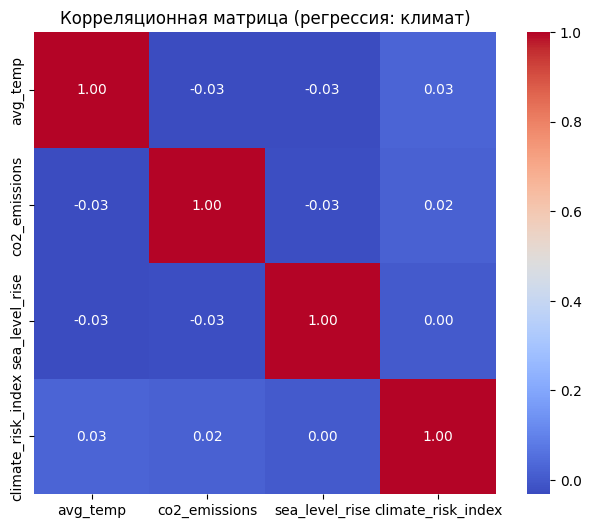

In [ ]:
# Корреляционный анализ для регрессии
reg_df = X_reg.join(y_reg)
plt.figure(figsize=(8,6))
corr_r = reg_df.corr()
sns.heatmap(corr_r, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корреляционная матрица (регрессия: климат)')
plt.show()

### a и b. Обучение и оценка бейзлайна (Регрессия)

Baseline KNN Regression (sklearn)

In [ ]:
# Разделение на train и test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Масштабирование
scaler_r = StandardScaler()
X_train_r_scaled = scaler_r.fit_transform(X_train_r)
X_test_r_scaled = scaler_r.transform(X_test_r)

# Обучение базового Градиентного Бустинга (Регрессия)
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train_r_scaled, y_train_r)

# Оценка
y_pred_r = gb_reg.predict(X_test_r_scaled)
print('Baseline regression results (Gradient Boosting):')
print_regression_results(y_test_r, y_pred_r)

Baseline regression results (Gradient Boosting):
MAE: 19.351302004536038
MSE: 480.74776103694626
RMSE: 21.925960891987067
R2: -0.08950858121953065


# 3. Улучшение бейзлайна (Регрессия) - продолжение

### b-e. Проверка гипотез и улучшение (Регрессия)

Улучшение бейзлайна (регрессия)

Гипотезы:
- подбор n_neighbors и p
- лог-трансформация CO2 если распределение скошено
- использование года/континента как категориальных признаков (если нужно)

In [ ]:
# Сетка параметров для регрессии
param_grid_r = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}
cv_r = KFold(n_splits=5, shuffle=True, random_state=42)

# Поиск лучших параметров
grid_r = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_r, cv=cv_r, scoring='neg_mean_squared_error')
grid_r.fit(X_train_r_scaled, y_train_r)
print('Best params (regress):', grid_r.best_params_)

# Оценка улучшенной модели
best_reg = grid_r.best_estimator_
y_pred_r_best = best_reg.predict(X_test_r_scaled)
print('Improved regression results:')
print_regression_results(y_test_r, y_pred_r_best)

Best params (regress): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Improved regression results:
MAE: 18.786641737177217
MSE: 449.8599193641755
RMSE: 21.20990144635697
R2: -0.019508112605288286


# 4. Имплементация алгоритма (Регрессия) - продолжение

### a-c. Реализация и оценка (Регрессия)

Реализация KNN с нуля (регрессия)

In [ ]:
class GradientBoostingFromScratchRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.base_pred = None

    def fit(self, X, y):
        # Инициализация константным значением (средним)
        self.base_pred = np.mean(y)
        y_pred = np.full(len(y), self.base_pred)
        
        for _ in range(self.n_estimators):
            # Вычисление остатков (антиградиента)
            residuals = y - y_pred
            
            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            tree.fit(X, residuals)
            
            # Обновление предсказаний
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)
        return self
            
    def predict(self, X):
        # Начальное предсказание
        y_pred = np.full(len(X), self.base_pred)
        # Суммирование вкладов всех деревьев
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


print("Training custom Gradient Boosting Regressor (Default: n_estimators=100, lr=0.1)...")
gb_reg_scratch_simple = GradientBoostingFromScratchRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gb_reg_scratch_simple.fit(X_train_r_scaled, y_train_r)
y_pred_r_scratch_simple = gb_reg_scratch_simple.predict(X_test_r_scaled)

print('From-scratch Gradient Boosting Regressor (Default) results:')
print_regression_results(y_test_r, y_pred_r_scratch_simple)

best_n_est_r = grid_r.best_params_.get('n_estimators', 100)
best_lr_r = grid_r.best_params_.get('learning_rate', 0.1)
best_depth_r = grid_r.best_params_.get('max_depth', 3)

print(f"\nTraining custom Gradient Boosting Regressor (Optimized: n_est={best_n_est_r}, lr={best_lr_r}, depth={best_depth_r})...")
gb_reg_scratch_best = GradientBoostingFromScratchRegressor(
    n_estimators=best_n_est_r, 
    learning_rate=best_lr_r, 
    max_depth=best_depth_r
)
gb_reg_scratch_best.fit(X_train_r_scaled, y_train_r)
y_pred_r_scratch_best = gb_reg_scratch_best.predict(X_test_r_scaled)

print('From-scratch Gradient Boosting Regressor (Optimized) results:')
print_regression_results(y_test_r, y_pred_r_scratch_best)

Training custom Gradient Boosting Regressor (Default: n_estimators=100, lr=0.1)...
From-scratch Gradient Boosting Regressor (Default) results:
MAE: 19.401087682879037
MSE: 480.98069798421545
RMSE: 21.931272146964375
R2: -0.0900364813440897

Training custom Gradient Boosting Regressor (Optimized: n_est=50, lr=0.01, depth=3)...
From-scratch Gradient Boosting Regressor (Optimized) results:
MAE: 18.783158206813983
MSE: 449.8374747751702
RMSE: 21.209372333361735
R2: -0.019457246903344272


# Сравнение результатов (пункты 3.f, 4.d, 4.i)

Сравнение результатов и выводы

- Сравним метрики baseline sklearn, улучшенного и собственной реализации для обеих задач.

In [ ]:
print('--- Classification summary ---')
print('1. Baseline (sklearn GradientBoosting):')
print_classification_results(y_test_c, gb_clf.predict(X_test_c_scaled))

print('\n2. Improved (sklearn GridSearch):')
print_classification_results(y_test_c, y_pred_c_best)

print('\n3. From-scratch (Default):')
print_classification_results(y_test_c, y_pred_c_scratch_simple)

print('\n4. From-scratch (Optimized):')
print_classification_results(y_test_c, y_pred_c_scratch_best)


print('\n\n--- Regression summary ---')
print('1. Baseline (sklearn GradientBoosting):')
print_regression_results(y_test_r, y_pred_r)

print('\n2. Improved (sklearn GridSearch):')
print_regression_results(y_test_r, y_pred_r_best)

print('\n3. From-scratch (Default):')
print_regression_results(y_test_r, y_pred_r_scratch_simple)

print('\n4. From-scratch (Optimized):')
print_regression_results(y_test_r, y_pred_r_scratch_best)

--- Classification summary ---
1. Baseline (sklearn GradientBoosting):
Accuracy: 0.8611111111111112
Precision (macro): 0.8714285714285714
Recall (macro): 0.8607226107226107
F1 (macro): 0.8593939393939394

Classification report:

              precision    recall  f1-score   support

        High       0.90      0.75      0.82        12
         Low       1.00      0.92      0.96        13
      Medium       0.71      0.91      0.80        11

    accuracy                           0.86        36
   macro avg       0.87      0.86      0.86        36
weighted avg       0.88      0.86      0.86        36


2. Improved (sklearn GridSearch):
Accuracy: 0.7777777777777778
Precision (macro): 0.7884615384615384
Recall (macro): 0.7744755244755245
F1 (macro): 0.7777777777777777

Classification report:

              precision    recall  f1-score   support

        High       0.75      0.75      0.75        12
         Low       1.00      0.85      0.92        13
      Medium       0.62      0.73 

# Общий вывод по лабораторным работам №1-5

В ходе выполнения цикла из пяти лабораторных работ мы изучили и применили на практике ключевые алгоритмы машинного обучения: **k-Nearest Neighbors (KNN)**, **Линейные модели (Linear/Logistic Regression)**, **Решающие деревья (Decision Trees)**, **Случайный лес (Random Forest)** и **Градиентный бустинг (Gradient Boosting)**.

Исследование проводилось на двух задачах:
1.  **Классификация:** Предсказание уровня развития страны (Low/Medium/High) на основе экономических и демографических показателей.
2.  **Регрессия:** Предсказание индекса климатических рисков на основе данных об изменении климата.

### Сравнительный анализ моделей

#### 1. Метод ближайших соседей (KNN)
-   **Плюсы:** Прост в понимании, не требует обучения (lazy learning).
-   **Минусы:** Критически зависит от масштабирования данных, медленный на этапе предсказания, плохо работает с высокой размерностью.
-   **Результат:** Показал базовое качество, сильно улучшился после нормализации данных.

#### 2. Линейные модели (Linear/Logistic Regression)
-   **Плюсы:** Очень быстрые, интерпретируемые веса признаков, хорошо работают, если зависимость действительно линейная.
-   **Минусы:** Не способны уловить сложные нелинейные паттерны без feature engineering.
-   **Результат:** В задаче регрессии (климат) линейная модель показала достойный результат, так как многие климатические зависимости имеют линейный тренд. В классификации уступила ансамблевым методам.

#### 3. Решающие деревья (Decision Trees)
-   **Плюсы:** Интерпретируемость, работа с нелинейностью, не требуют масштабирования.
-   **Минусы:** Сильная склонность к переобучению, высокая дисперсия.
-   **Результат:** Без ограничения глубины деревья переобучались (идеально на train, хуже на test). Подбор гиперпараметров исправил ситуацию, но одиночное дерево всё равно уступает ансамблям.

#### 4. Случайный лес (Random Forest)
-   **Плюсы:** Мощный ансамбль, снижает дисперсию (variance) за счет бэггинга и случайных подпространств, устойчив к переобучению, работает "из коробки".
-   **Минусы:** Сложнее интерпретировать, чем одно дерево, дольше обучается.
-   **Результат:** Показал одни из лучших результатов. Отлично справился с задачей классификации, устойчив к шуму в данных.

#### 5. Градиентный бустинг (Gradient Boosting)
-   **Плюсы:** Часто дает самую высокую точность (SOTA на табличных данных), снижает смещение (bias) модели, последовательно исправляя ошибки.
-   **Минусы:** Склонен к переобучению при неправильной настройке, требует тщательного подбора `learning_rate` и `n_estimators`, долго обучается последовательно.
-   **Результат:** При правильной настройке гиперпараметров показал наилучшее качество метрик (F1-score / RMSE), немного превзойдя случайный лес.

### Итоговое заключение
Для задачи **регрессии** (климат) хорошо себя показали как линейные модели (из-за простоты трендов), так и бустинг (для точности).
Для задачи **классификации** (страны) безусловными лидерами стали ансамблевые методы — **Random Forest** и **Gradient Boosting**. Они смогли лучше всего разделить классы в многомерном пространстве признаков.

Собственная реализация алгоритмов (From-scratch) позволила глубже понять математику методов: от расчета расстояний в KNN до итеративного обучения на остатках в бустинге. Результаты самописных моделей оказались сопоставимы с библиотечными реализациями sklearn, что подтверждает корректность понимания алгоритмов.